# EEG Data Processing

### About the dataset

The EEG data used is a database collected and made available by the Child Mind Institute. It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

Words, words, words

In [1]:
%matplotlib inline

import os
import csv
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom imports
from slf.eeg import *
from slf.core.db import SLFDB
from slf.core.io import save_pickle, load_pickle

# Import FOOOF
from fooof import FOOOF

### Checking 

In [2]:
# Initialize project database object
db = SLFDB()
subjs = db.check_subjs()

In [3]:
# Load data readme file
rmd_file = os.path.join(db.data_path, 'EEG', 'MIPDB_PublicFile.csv')
df = pd.read_csv(rmd_file)

In [4]:
# Check which subjects are downloaded
all_subjs = set(df.ID)

# Subjects with no data (info from README)
no_dat = ['A00052593', 'A00054122', 'A00055801', 'A00056158', 'A00056640', 'A00056990']

# Check if any subjects still need downloading
to_dl = all_subjs - set(subjs) - set(no_dat)

# Print out results
print('Number of subjects downloaded: ', len(set(subjs)))
print('Number of subjects left to download: ', len(to_dl))

Number of subjects downloaded:  120
Number of subjects left to download:  0


### Subjects

In [5]:
# Set subject to run
cur_subj = subjs[90]

# Get subject data files
dat_f, ev_f, _ = db.get_subj_files(cur_subj)

In [6]:
# Get the resting data file - file 001
temp = [ef.split('_')[1] for ef in ev_f]
temp = [fn[-3:] for fn in temp]
f_ind = None
for i, tt in enumerate(temp):
    if tt == '001':
        f_ind = i
if f_ind is None:
    print('No file found')

In [7]:
# Get file file path for data file & associated event file
dat_f_name = db.gen_dat_path(cur_subj, dat_f[f_ind])
eve_f_name = db.gen_dat_path(cur_subj, ev_f[f_ind])

In [8]:
# Data info / parameters
s_freq = 500

# Load data file
dat = np.loadtxt(dat_f_name, delimiter=',')

In [9]:
# Read in list of channel names that are kept in reduced 111 montage
with open('../data/chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

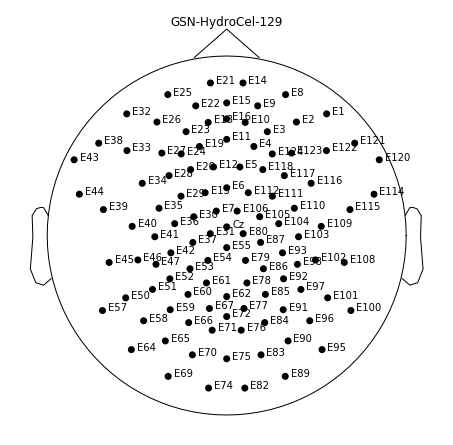

In [10]:
# Check out the montage plot
montage.plot();

In [11]:
# Create the info structure needed by MNE
info = mne.create_info(ch_labels, s_freq, 'eeg', montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(dat, info)

Creating RawArray with float64 data, n_channels=111, n_times=174329
    Range : 0 ... 174328 =      0.000 ...   348.656 secs
Ready.


In [12]:
# Create a stim channel
stim_info = mne.create_info(['stim'], s_freq, 'stim')
stim_raw = mne.io.RawArray(np.zeros(shape=[1, len(raw._times)]), stim_info)

# Add stim channel to data object
raw.add_channels([stim_raw], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=174329
    Range : 0 ... 174328 =      0.000 ...   348.656 secs
Ready.


<RawArray  |  None, n_channels x n_times : 112 x 174329 (348.7 sec), ~149.3 MB, data loaded>

In [13]:
# Load events from file

# Initialize headers and variable to store event info
headers = ['type', 'value', 'latency', 'duration', 'urevent']
evs = np.empty(shape=[0, 3])

# Load events from csv file
with open(eve_f_name, 'r') as csv_file:
    
    reader = csv.reader(csv_file)
    for row in reader:

        # Skip the empty rows
        if row == []: continue
        
        # Skip the header row, since there is one for every event...
        if row[0] == 'type': continue
        
        # Collect actual event data rows
        evs = np.vstack((evs, np.array([int(row[2]), 0, int(row[0])])))

# Add events to data object
raw.add_events(evs, stim_channel='stim')

# Check events
dat_evs = mne.find_events(raw)

12 events found
Events id: [20 30 90]


In [14]:
# Find flat channels and set them as bad
flat_chans = np.mean(raw._data[:111, :], axis=1) == 0
raw.info['bads'] = list(np.array(raw.ch_names[:111])[flat_chans])
print('Bad channels: ', raw.info['bads'])

Bad channels:  ['E8', 'E14', 'E21', 'E25', 'E32']


In [15]:
# Interpolate bad channels
raw.interpolate_bads()

Computing interpolation matrix from 106 sensor positions
Interpolating 5 sensors


<RawArray  |  None, n_channels x n_times : 112 x 174329 (348.7 sec), ~149.3 MB, data loaded>

In [16]:
# Set average reference
raw.set_eeg_reference()
raw.apply_proj()

The behavior of set_eeg_reference will change in 0.16 when ref_channels="average". Currently, a projection is computed, which has to be applied manually with the apply_proj method. In 0.16, the average reference will be directly applied. Set projection=True if you want to retain the old behavior, or set projection=False if you want the new behavior.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<ipython-input-16-20a53777281e>:2: DeprecationWarning: The behavior of set_eeg_reference will change in 0.16 when ref_channels="average". Currently, a projection is computed, which has to be applied manually with the apply_proj method. In 0.16, the average reference will be directly applied. Set projection=True if you want to retain the old behavior, or set projection=False if you want the new behavior.
  raw.set_eeg_reference()


<RawArray  |  None, n_channels x n_times : 112 x 174329 (348.7 sec), ~149.3 MB, data loaded>

## Resting EEG event descriptions

- 90: Start of the resting EEG paradigm
- 20: Eyes open start (20 seconds)
- 30: Eyes closed start (40 seconds)

^ There should be 5 of each EO and EC

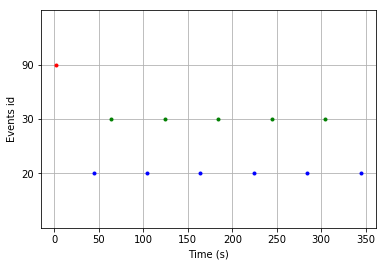

In [17]:
_ = mne.viz.plot_events(dat_evs, raw.info['sfreq'])

In [18]:
# Get good eeg channel indices
eeg_chans = mne.pick_types(raw.info, meg=False, eeg=True)

# Epoch resting eeg data events
eo_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EO': 20}, tmin=2, tmax=18,
                       baseline=None, picks=eeg_chans, preload=True)
ec_epochs = mne.Epochs(raw, events=dat_evs, event_id={'EC': 30}, tmin=2, tmax= 38,
                       baseline=None, picks=eeg_chans, preload=True)

6 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 6 events and 8001 original time points ...
1 bad epochs dropped
5 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 18001 original time points ...
0 bad epochs dropped


In [19]:
# Plot topo-plots of oscillatory activity
#eo_epochs.plot_psd_topomap();
#ec_epochs.plot_psd_topomap();

In [20]:
# Calculate PSDs - EO Data
eo_psds, eo_freqs = mne.time_frequency.psd_welch(eo_epochs, fmin=2., fmax=40., n_fft=1000,
                                                 n_overlap=250, verbose=False)

# Average PSDs for each channel across each rest block
eo_avg_psds = np.mean(eo_psds, axis=0)

In [21]:
# Calculate PSDs - EC Data
ec_psds, ec_freqs = mne.time_frequency.psd_welch(ec_epochs, fmin=3., fmax=40., n_fft=1000,
                                                 n_overlap=250, verbose=False)

# Average PSDs for each channel across each rest block
ec_avg_psds = np.mean(ec_psds, axis=0)

In [22]:
# Save out PSDs
#np.savez(str(cur_subj) + 'ec_psds.npz', ec_freqs, ec_avg_psds, np.array(ec_epochs.ch_names))
#np.savez(str(cur_subj) + 'eo_psds.npz', eo_freqs, eo_avg_psds, np.array(eo_epochs.ch_names))

### Words


                                          FOOOF - PSD MODEL                                          

                      The input PSD was modeled in the frequency range 3-35 Hz                      
                                 Frequency Resolution is 0.50 Hz 
                                  
                              Background Parameters (offset, slope):                                
                                           0.4468, 1.5440                                           

                                      4 oscillations were found:                                     
                                 CF:   8.99, Amp:  0.467, BW:  3.16                                 
                                 CF:  12.28, Amp:  0.240, BW:  1.00                                 
                                 CF:  18.68, Amp:  0.384, BW:  4.56                                 
                                 CF:  23.52, Amp:  0.232, BW:  2.63                   

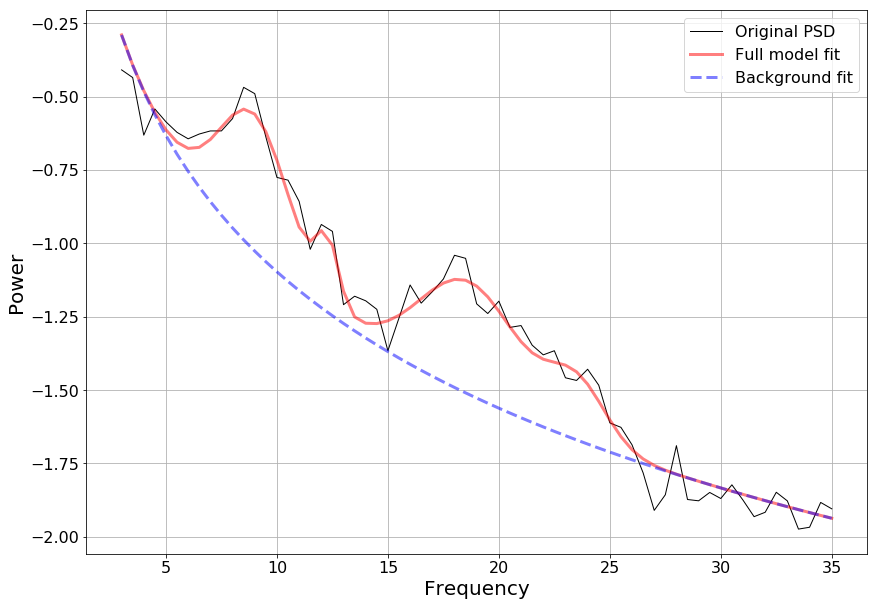

In [23]:
# Fit FOOOF, to example PSD
f_range = [3, 35]
fm = FOOOF(bandwidth_limits=[1, 8], max_n_oscs=6, min_amp=0.2)
fm.model(eo_freqs, eo_avg_psds[65, :], f_range)

In [24]:
# Fit FOOOF to PSDs averaged across rest epochs
fres_eo_avg = fit_fooof_lst(eo_freqs, eo_avg_psds)
sls_eo_avg = get_slopes(fres_eo_avg)
fres_ec_avg = fit_fooof_lst(ec_freqs, ec_avg_psds)
sls_ec_avg = get_slopes(fres_ec_avg)

In [25]:
# Fit FOOOF to PSDs from each epoch
fres_eo = fit_fooof_3d(eo_freqs, eo_psds)
sls_eo = [get_slopes(lst) for lst in fres_eo]
fres_ec = fit_fooof_3d(ec_freqs, ec_psds)
sls_ec = [get_slopes(lst) for lst in fres_ec]

In [26]:
# Get the average slope values 
eo_avgs = [np.mean(sls) for sls in sls_eo]
ec_avgs = [np.mean(sls) for sls in sls_ec]

# Check out the average values
print(np.mean(eo_avgs))
print(np.mean(ec_avgs))

1.39682844917
1.36612127317


In [27]:
# Check range of slopes
print(min(sls_eo_avg))
print(max(sls_eo_avg))

print(min(sls_ec_avg))
print(max(sls_ec_avg))

1.14586929298
1.85056018811
1.06667711607
2.17917065696


In [28]:
# Collect data together
subj_dat = {
    'ID' : cur_subj,
    'sls_eo_avg' : sls_eo_avg,
    'sls_ec_avg' : sls_ec_avg,
    'sls_eo' : sls_eo,
    'sls_ec' : sls_ec
}

In [29]:
# Save out data
f_name = 'test_subj.p'
save_pickle(subj_dat, f_name, db.fooof_path)

In [30]:
# Check for saved FOOOF files
fres_files = db.check_fooof()
f_ind = fres_files.index(f_name)

In [31]:
# Load pickle file of FOOOF results
dat = load_pickle(fres_files[f_ind], db.fooof_path)

### Words

In [32]:
from matplotlib import cm

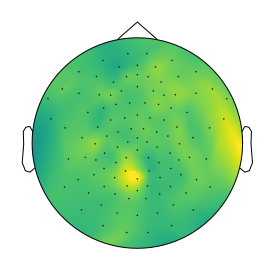

In [33]:
# Plot slope topography from average eyes-open data
mne.viz.plot_topomap(sls_eo_avg, raw.info, cmap=cm.viridis, contours=0);

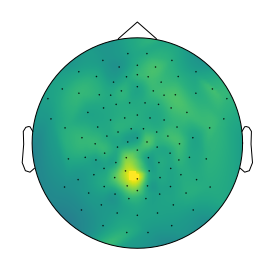

In [34]:
# Plot slope topography from average eyes-closed data
mne.viz.plot_topomap(sls_ec_avg, raw.info, cmap=cm.viridis, contours=0);

In [35]:
#
corrs_eo = comb_corrs(sls_eo)
print('Corrs within EO: \t', np.mean(corrs_eo))
    
corrs_ec = comb_corrs(sls_ec)
print('Corrs within EC: \t', np.mean(corrs_ec))

corrs_bet = bet_corrs(sls_eo, sls_ec)
print('Corrs betwee EC/EO: \t', np.mean(corrs_bet))

Corrs within EO: 	 0.311984506056
Corrs within EC: 	 0.583689339991
Corrs betwee EC/EO: 	 0.457475140693


In [37]:
# for sls in sls_ec:
#     mne.viz.plot_topomap(sls, raw.info, cmap=cm.viridis, contours=0);

In [38]:
#
diff_sl = [sec - seo for sec, seo in zip(sls_ec_avg, sls_eo_avg)]

print(min(diff_sl))
print(max(diff_sl))

-0.290369121588
0.328610468848


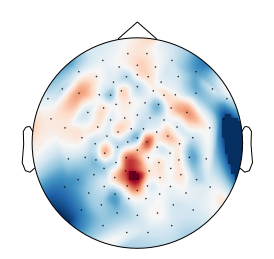

In [39]:
mne.viz.plot_topomap(diff_sl, raw.info, contours=0);

### Extra / Old Stuff

In [40]:
# Plot a PSD
#plt.plot(np.log10(ec_freqs), np.log10(ec_avg_psds[0, :]))

In [41]:
# Plot some epoched data
#eo_epochs.plot(scalings=dict(eeg=10));

In [42]:
# Plot some raw data
#raw.plot(start=100, duration=2, scalings=dict(eeg=10))

In [43]:
# This copied from automagic preprocess script
#chan128 = [2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27,
#            28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51,
#            52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76,
#            77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 95, 96, 97, 98, 100,
#            101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 114, 115, 116, 117,
#            118, 120, 121, 122, 123, 124, 129];

In [44]:
# %autoreload 2

# from slf.core.db import SLFDB
# db = SLFDB()